<a href="https://colab.research.google.com/github/Colley-K/rock_climbing_recommendation_system/blob/master/Tall_vs_Short_Climbing_Grades.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Are Short or Tall Climbers Climbing Harder Grades? 
## Background 
There has always been a sterotype in climbing, that tall people are better at climbing than short people. In this analysis, I will take a current log of 4 million rock climbs to test that notion and compare the average of a "tall" person's rock climbing grades to that of "short" person. Using a hypothesis test, I will test whether or not these averages are stastically the same, or if they are in fact different. 

## Data
Imported from Kaggle, the 8a.nu climbing data set contains 4 tables, and is filled with 4 million entries of different rock climbs from its' users. All entries are user recorded, and prone to user error or exageration so this analysis must be taken with a little skepticism. I will clean the data to try to filter out some of the outstandingly obvious falsified entries.

## Filtering Data
One of the biggest hurdles in analyzing this data is the question of where exactly to slice the data to represent short, average, and tall. I've researched many sources of average height, but the truth is that it varies so much from country to country, and culture to culture. Given this is one of the more internationally logged climbing datasets, it would be horribly inaacurate to choose an average height from an outside source. Thus, my apporach will be to separate the dataset into male verus female and assign the average label as anything in the inner quartile range given the sex, and then anything above it to be the large extreme and anything below it to be the small extreme. This will create a bias in this analysis, and in future research it would a great idea to test different segmenting options.

## Importing from Kaggle
Using the Kaggle API, this dataset was downloaded as an SQLite database, transformed into a Pandas dataframe, and then exported as a CSV

>Click [here](https://colab.research.google.com/drive/1S4io5Nvz0lcnri_Lz9Mpa_TwLNeoSzGb#scrollTo=0BhPF3cSDvYk) to view the import notebook

>Click [here](https://www.kaggle.com/dcohen21/8anu-climbing-logbook) to view the data set on Kaggle 

_____

## Initial Setup

In [0]:
#Colab stuffs:

#get a fast operator system
!nvidia-smi

#mount google drive
from google.colab import drive
drive.mount('/content/drive')#click on the link it provides and copy and paste that code into the authorization area
!ls "/content/drive/My Drive" #shows whats in your drive once its mounted

#access the OS system to work with current directories:
import os 
os.getcwd() 

#Imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy import stats
from statsmodels.stats import weightstats as stests
from scipy.stats import ttest_1samp
import math


Tue Jun 18 18:44:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import CSV Files

In [0]:
#Turn the CSV files into data frames

ascent = pd.read_csv('drive/My Drive/Capstone/ascent.csv', low_memory=False) 

user = pd.read_csv('drive/My Drive/Capstone/data/user.csv', low_memory=False) 

grade = pd.read_csv('drive/My Drive/Capstone/data/grade.csv', low_memory=False) 

## Clean Up & Merge 3 Dataframes


*   Drop unneccesary columns in all three columns
*   Forward fill the "grade table" so all grade_is correspond to a difficulty number
* Drop any nulls
* Filter out any users that entered extreme weights or height values because their entries cannot be trusted to be valid information
* Turn all floats into integers because floats are not needed for whole numbers



In [0]:
#Trimming all three data frames to only the necessary columns

#Dropping Columns
a_cols = ["user_id", "grade_id", "climb_type"]
u_cols = ["id", "sex", "height", "weight"]
g_cols = ["id","usa_routes", "usa_boulders"]

ascent = ascent[a_cols]
user= user[u_cols]
grade = grade[g_cols]

In [0]:
#Forward filling the rock climbing grades

grade[["usa_routes", "usa_boulders"]]= grade[["usa_routes", "usa_boulders"]].fillna(method='ffill')

In [0]:
#Drop all null values
ascent= ascent.dropna(axis=0) 
user = user.dropna(axis=0)
grade = grade.dropna (axis= 0)

### Merging the 3 Dataframes

In [0]:
#Left merge the ascent table with user table
ascent = ascent.merge(user,how='left', left_on='user_id', right_on='id')

In [0]:
#Left merge the ascent table with grade table
rock = ascent.merge(grade,how='left', left_on='grade_id', right_on='id')

In [0]:
#Drop unnecessary columns
rock = rock.drop(["id_x", "id_y"], axis= 1)

In [0]:
#Cleaning up sex, weight, height columns
rock = rock[rock.sex != 255]
rock = rock[(rock.height > 134) & (rock.height < 215)] #weeding out extreme entries that are less than 4 feet 5 inches tall & taller than 7 feet
rock = rock[(rock.weight > 30)] #weeding out a person that weighs less than 70 lbs

In [0]:
#converting floats to integers
cols= ["sex", "height", "weight", "grade_id", "climb_type", "user_id"]
rock[cols] = rock[cols].astype('int64')

In [0]:
rock.head()

,user_id,grade_id,climb_type,sex,height,weight,usa_routes,usa_boulders
0,1,36,0,0,177,73,5.10a,V3
1,1,36,0,0,177,73,5.10a,V3
2,1,36,0,0,177,73,5.10a,V3
3,1,36,0,0,177,73,5.10a,V3
4,1,36,0,0,177,73,5.10a,V3


______
## Separating out Tall vs. Short 


1. Segment out height  categories with gender in mind 
>* Instead of taking the average height or weight from a country-wide study, I will be basing my categories off of this specific climbing log's population. 
>* "Average" categories in height will be based on the inner quartile range for each gender
>* All other categories("short", "tall") will be measured above or below the IQR's of this dataset based on sex
2. Create separate data frames based on this



In [0]:
#Female height stats
rock[rock.sex == 1].describe()

# short= <158
# avg=158-170
# tall= >170


,user_id,grade_id,climb_type,sex,height,weight
count,246396.000000,246396.000000,246396.000000,246396.0,246396.000000,246396.000000
mean,30234.513718,43.646094,0.208912,1.0,164.513304,54.187426
std,17493.507404,9.214684,0.406532,0.0,7.202574,7.432530
min,4.000000,7.000000,0.000000,1.0,135.000000,40.000000
25%,16501.000000,38.000000,0.000000,1.0,160.000000,48.000000
50%,28706.000000,44.000000,0.000000,1.0,165.000000,53.000000
75%,42935.000000,51.000000,0.000000,1.0,170.000000,58.000000
max,67015.000000,75.000000,1.000000,1.0,200.000000,100.000000


In [0]:
#Male height stats
rock[rock.sex == 0].describe()

# short= <174
# avg= 174-183
# tall= >183

,user_id,grade_id,climb_type,sex,height,weight
count,2.577157e+06,2.577157e+06,2.577157e+06,2577157.0,2.577157e+06,2.577157e+06
mean,2.556321e+04,4.698894e+01,2.992057e-01,0.0,1.778378e+02,7.001573e+01
std,1.720688e+04,9.229671e+00,4.579102e-01,0.0,7.078003e+00,8.390036e+00
min,1.000000e+00,1.000000e+00,0.000000e+00,0.0,1.350000e+02,4.000000e+01
25%,1.073800e+04,4.000000e+01,0.000000e+00,0.0,1.730000e+02,6.300000e+01
50%,2.317200e+04,4.900000e+01,0.000000e+00,0.0,1.780000e+02,6.800000e+01
75%,3.797200e+04,5.300000e+01,1.000000e+00,0.0,1.820000e+02,7.300000e+01
max,6.702500e+04,8.300000e+01,1.000000e+00,0.0,2.120000e+02,1.000000e+02


In [0]:
#creating 3 different data frames for height & weight differences
h_tall = rock[((rock.sex == 1) & (rock.height > 170)) | ((rock.sex == 0) & (rock.height > 183))]
h_short = rock[((rock.sex == 1) & (rock.height < 158)) | ((rock.sex == 0) & (rock.height < 174))]
h_avg = rock[((rock.sex == 1) & ((rock.height >= 158) & (rock.height <= 170)) | ((rock.sex == 0) & ((rock.height >= 174) & (rock.height <= 183))))]


_______
## Tall vs. Short  EDA
* In this section I will separated out tall versus short data
* Look at the summary stastistics of each table
* Visualize the differences between tall vs. short grades

In [0]:
#TALL vs SHORT Labelling the means
h_tall_mu = h_tall.grade_id.mean()
h_short_mu = h_short.grade_id.mean()
h_avg_mu = h_avg.grade_id.mean()#for fun
print (f"Short climber average difficulty: {h_short_mu}")
print (f"Average climber average difficulty: {h_avg_mu}")
print (f"Tall climber average difficulty: {h_tall_mu}")

Short climber average difficulty: 47.72713102094409
Average climber average difficulty: 46.689818030281984
Tall climber average difficulty: 45.36608887795848


In [0]:
#Short summary stastistics
h_short.describe()

,user_id,grade_id,climb_type,sex,height,weight
count,699911.000000,699911.000000,699911.000000,699911.000000,699911.000000,699911.000000
mean,26370.692461,47.727131,0.283236,0.048905,168.320226,62.658032
std,17385.393721,9.416807,0.450570,0.215669,5.735909,7.671320
min,10.000000,7.000000,0.000000,0.000000,135.000000,40.000000
25%,11753.000000,40.000000,0.000000,0.000000,167.000000,58.000000
50%,24377.000000,49.000000,0.000000,0.000000,170.000000,63.000000
75%,38874.000000,55.000000,1.000000,0.000000,172.000000,68.000000
max,67019.000000,83.000000,1.000000,1.000000,173.000000,100.000000


In [0]:
#Tall summary stastistics
h_tall.describe()

,user_id,grade_id,climb_type,sex,height,weight
count,532663.000000,532663.000000,532663.000000,532663.000000,532663.000000,532663.000000
mean,25273.738262,45.366089,0.305630,0.081308,186.562175,76.053920
std,17388.492937,9.103909,0.460674,0.273308,4.927101,8.682478
min,6.000000,7.000000,0.000000,0.000000,171.000000,40.000000
25%,10115.000000,40.000000,0.000000,0.000000,185.000000,73.000000
50%,22986.000000,46.000000,0.000000,0.000000,186.000000,78.000000
75%,37569.000000,51.000000,1.000000,0.000000,189.000000,83.000000
max,67022.000000,83.000000,1.000000,1.000000,212.000000,100.000000


In [0]:
#creating a dictionary & list to make sense of the grade_id's
climb_ratings= rock.set_index('grade_id').to_dict()['usa_routes']
print (climb_ratings)
full_ratings= ['3/4', '5.1', '5.2', '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9','5.10a','5.10b','5.10c','5.10d','5.11a', '5.11b','5.11d','5.12a','5.12b','5.12c','5.12d','5.13a','5.13b','5.13c','5.13d','5.14a','5.14b','5.14b/c','5.14c', '5.14d', '5.15a', '5.15b', '5.15c']

{36: '5.10a', 38: '5.10b', 40: '5.10c', 42: '5.10d', 44: '5.11a', 46: '5.11b', 49: '5.11d', 51: '5.12a', 53: '5.12b', 55: '5.12c', 57: '5.12d', 62: '5.13b', 59: '5.13a', 64: '5.13c', 66: '5.13d', 72: '5.14c', 68: '5.14a', 70: '5.14b', 75: '5.14d', 31: '5.8', 33: '5.9', 21: '5.4', 29: '5.7', 13: '5.3', 1: '3/4', 71: '5.14b/c', 77: '5.15a', 73: '5.14c/d', 23: '5.5', 25: '5.6', 17: '5.3', 15: '5.3', 79: '5.15b', 7: '5.1', 83: '5.15c', 81: '5.15c'}


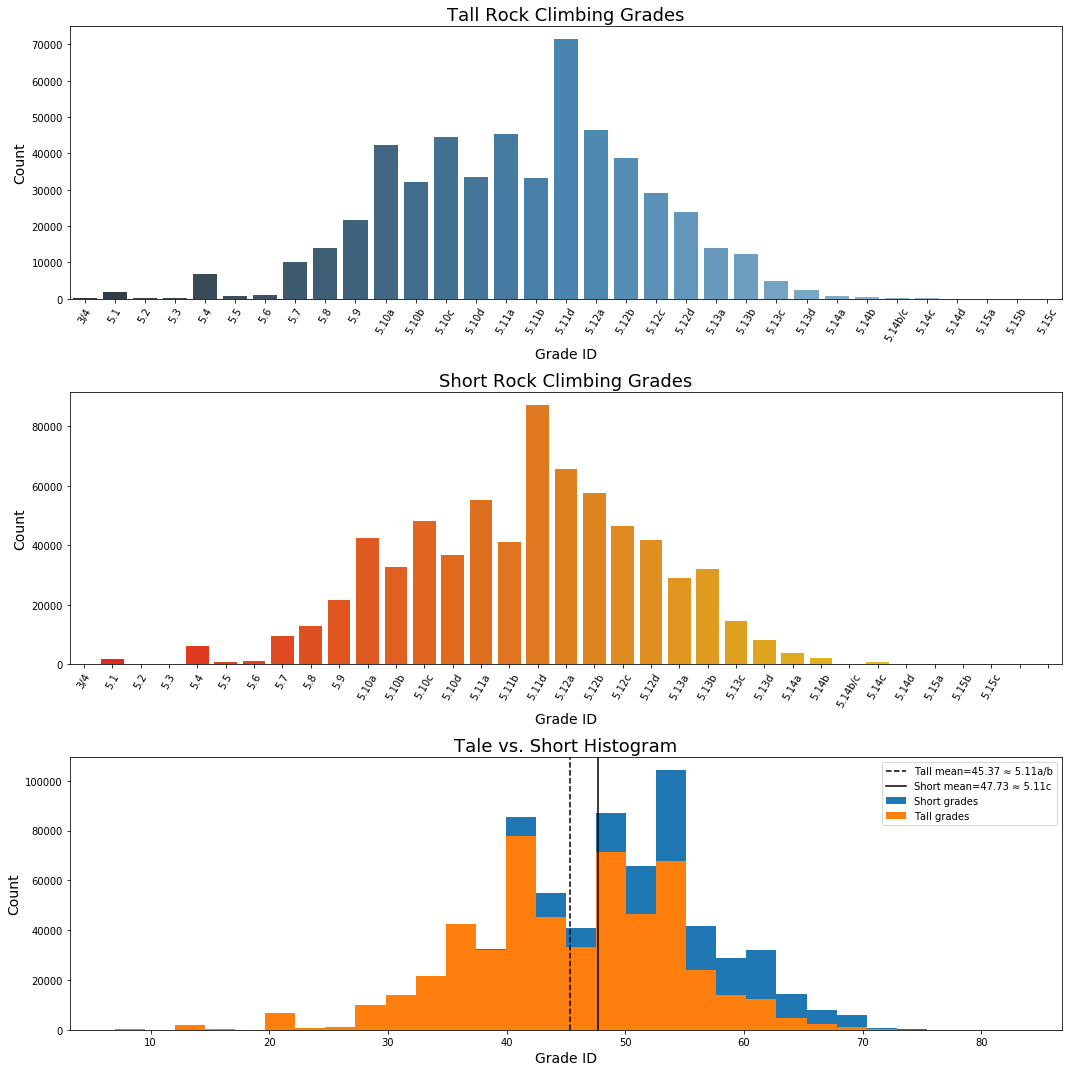

In [0]:
# Graphing Tall versus Short

fig= plt.figure(figsize=(15,15))

#Tall 
ax1 = fig.add_subplot(3,1,1)
sns.countplot(x='grade_id', data=h_tall, palette = "Blues_d")
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title("Tall Rock Climbing Grades", fontsize= 18)
ax1.set_xticklabels(full_ratings, rotation= 60)

#Short
ax2 = plt.subplot(3,1,2)
sns.countplot(x="grade_id", data= h_short, palette = "autumn")
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title("Short Rock Climbing Grades", fontsize= 18)
ax2.set_xticklabels(full_ratings, rotation= 60)

#joint histogram
plt.subplot (3,1,3)
plt.hist(h_short["grade_id"],bins=30, label= "Short grades")
plt.hist(h_tall["grade_id"],bins=30, label= "Tall grades")
plt.axvline(h_tall_mu, color='k',linestyle='dashed', label=(f'Tall mean={h_tall_mu:.2f} ≈ 5.11a/b'))
plt.axvline(h_short_mu, color='k', label=(f'Short mean={h_short_mu:.2f} ≈ 5.11c'))
plt.xlabel("Grade ID", fontsize= 14)
plt.ylabel("Count", fontsize= 14)
plt.title('Tale vs. Short Histogram', fontsize= 18)
plt.legend()

plt.tight_layout()

In [0]:
#Function for generating "short", "average", and "tall" labels

def height (x):
  if x.sex == 0:
    if x.height < 174:
      return "Short"
    elif x.height >= 174 and x.height <=183:
      return "Average"
    else:
      return "Tall"
  else:
    if x.height < 158:
      return "Short"
    elif x.height >= 158 and x.height <=170:
      return "Average"
    else:
      return "Tall"

rock["height_label"] = rock[['sex', 'height']].apply (height, axis=1)

No handles with labels found to put in legend.


<function matplotlib.pyplot.show>

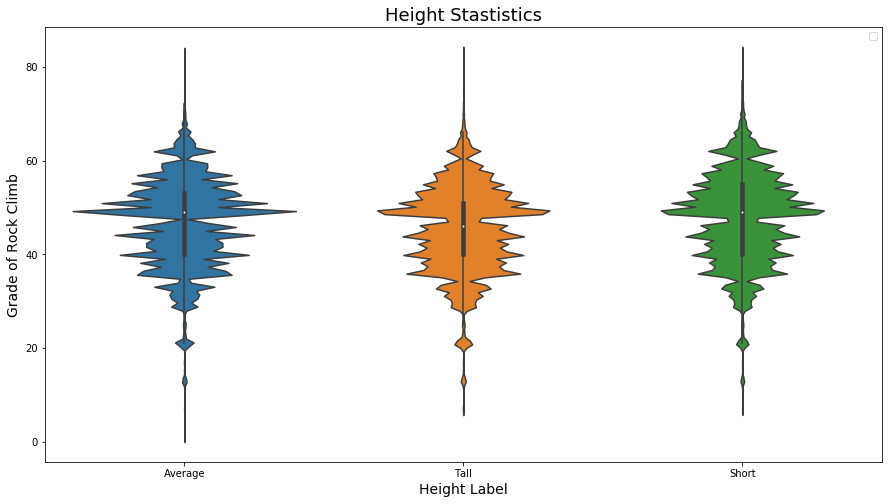

In [0]:
#Generate Plot
fig, ax = plt.subplots(figsize=(15,8))
sns.violinplot(x="height_label", y="grade_id", data = rock)
plt.title("Height Stastistics", fontsize=18)
plt.xlabel("Height Label", fontsize= 14)
plt.ylabel("Grade of Rock Climb", fontsize= 14)
plt.show

## Initial Impressions from EDA


*   Suprisingly short climbers have the highest climbing grade average at 47.727 (approximately an 5.11c)! This is contrary to popular thought that tall people are better climbers.
* There are slightly more outliers in the average category which makes sense being that it is the largest represented category
* All three heigh categories have a spike at around the climbing rating of 49 or 5.11d.
_____




# Hypothesis Test

### Process
1. State the hypothesis and significance level
2. For fun, try a T-test and a Z-test to test the hypothesis, and see if there are differing results 

### Stating the Hypothesis & Alpha:
* Null hypothesis 
>$H_0: \mu1 = \mu2 $
>*There is no difference between the average short & tall climbing grades*

* Alternative hypothesis 
> $ H_1: \mu1 > \mu2 $
>*Average short climbing grades are higher than tall climbing grades*

* Significance Level
> $ {\alpha = .01} $

In [0]:
#Restating the means
print (f"Tall climber average difficulty: {h_tall_mu}")
print (f"Short climber average difficulty: {h_short_mu}")

Tall climber average difficulty: 45.36608887795848
Short climber average difficulty: 47.72713102094409


In [0]:
#Concatenate the tall & short df's together, calculate their combined mean, and turn both columns into arrays

#concatenating the two subsetted data frames
combined_df= pd.concat([h_tall, h_short])

#computing the combined mean
combined_mean= np.mean(combined_df["grade_id"])
print (f"Combined mean: {combined_mean}")

#turning into arrays for functions
tall_arry = h_tall["grade_id"].values
short_arry = h_short["grade_id"].values

Combined mean: 46.70679488614882


In [0]:
#T-TEST two sample/one-tail

ttest, p = ttest_ind(short_arry,tall_arry)

#Results
print ("T-Test Results:")
print(f"P-value:{p:.5f}")
if p <0.01:
  print("we reject null hypothesis")
else:
  print("we accept null hypothesis")

T-Test Results:
P-value:0.00000
we reject null hypothesis


In [0]:
#Z-TEST two sample/one-tail 

#z-test 
ztest ,pval = stests.ztest(short_arry, x2=tall_arry, value=0)

#results
print("Z-Test Results:")
print(f"P-value:{pval:.5f}")
if pval < 0.01:    # alpha value is 1%
    print("We reject the null hypothesis")
else:
    print("We accept the null hypothesis")
    
# Compute mean and standard deviation of the current sample: mu, sigma
n= len(rock["grade_id"])
sd = np.std(rock["grade_id"])
z= 2.575 #critical z-value for 99% confidence interval

#Compute the 99% confidence interval
margin_er = z * (sd/math.sqrt(n))

# Print the confidence interval & margin of error
print(f"The margin of error = {margin_er}")
print(f'The 99% confidence interval = [{combined_mean- margin_er}, {combined_mean + margin_er}]')

Z-Test Results:
P-value:0.00000
We reject the null hypothesis
The margin of error = 0.014215479244573143
The 99% confidence interval = [46.692579406904244, 46.7210103653934]


## Results & Conclusions


*   The p-value is incredibly small with both the T & Z tests, and it is stasistically not probable the the difference in short & tall climbing grades is due to chance 
*   Therefore, we can say that based on this dataset "short" climbers are in fact climbing harder grades on average than their taller counter parts.
* For future investigation:
 >* Experiment with different tall versus short segments of this dataset. I would be curious if the criteria for tall versus short was made even more extreme what that would do to the data
 >* Separate out bouldering climbing versus rock climbing and see how that changes the tall versus short averages (perhaps the style of climbing matters)
 >* Separate out male versus female and see if that changes the tall versus short dynamic and if one sex has more of an advantage there

